<a href="https://colab.research.google.com/github/MisaelManingo/ChemVATS/blob/main/THESIS_250k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **`ChemVATS`: Chemical Variational Autoencoder using Transformers for SELFIES**
formerly *Encoding and Decoding Molecules using Transformers*

Misael Andre D. Maningo | Dr. Miguel Francisco M Remolona

## A. Imports
Imports and installs to Google Colab.

In [ ]:
!pip install selfies
import selfies as sf

In [ ]:
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import Image, display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 32.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
# !pip install tensorflow==2.14
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D, Layer, Lambda, Add
from tensorflow.keras.models import Model, Sequential
from keras import backend as K
from collections import Counter

import random
import math
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns

In [ ]:
!pip install keras-nlp tensorflow==2.15 tensorflow-text==2.15 --upgrade -q
from keras_nlp.layers import TransformerEncoder, TransformerDecoder, SinePositionEncoding
from keras_nlp.samplers import GreedySampler, BeamSampler, TopKSampler, TopPSampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 30.5 MB/s eta 0:00:00
Using TensorFlow backend


Output wrapping in Google Colab.

In [ ]:
from IPython.display import HTML, display

#pre-wrap vs nowrap vs normal vs pre
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## B. Database

### B.1. Sample ZINC Database (250k)

In [ ]:
data_url = "https://github.com/aspuru-guzik-group/selfies/raw/16a489afa70882428bc194b2b24a2d33573f1651/examples/vae_example/datasets/dataJ_250k_rndm_zinc_drugs_clean.txt"
data_SMILES = pd.read_csv(data_url)
print("Total number of molecules in imported dataset:", len(data_SMILES))

Total number of molecules in imported dataset: 249455


Convert from SMILES to SELFIES.

In [ ]:
LOAD_FROM_FILE = True
MASTER_SELFIES_FILE_NAME = '/content/drive/MyDrive/Colab Notebooks/Models/master_SELFIES.txt'
# MASTER_SELFIES_FILE_NAME = '/content/drive/MyDrive/Colab Notebooks/Database/20M_SELFIES_Data.txt'

master_SELFIES = []

if not LOAD_FROM_FILE:
    master_SELFIES = [sf.encoder(s) for s in data_SMILES.iloc[0:len(data_SMILES)-1, 0]]
    with open(MASTER_SELFIES_FILE_NAME, 'w') as file:
        for item in master_SELFIES:
            file.write(f"{item}\n")
else:
    with open(MASTER_SELFIES_FILE_NAME, 'r') as file:
        for line in file:
            master_SELFIES.append(line.strip())

max_length = max(sf.len_selfies(s) for s in master_SELFIES)

## C. Data Preprocessing

### C.1. SELFIES Encoding

Lists all unique symbols from master data set and makes a look-up table.

In [ ]:
alphabet = sf.get_alphabet_from_selfies(master_SELFIES)
alphabet = list(sorted(alphabet))  # ['[=O]', '[C]', '[F]', '[O]', '[nop]']
alphabet.insert(0, "[nop]") # [nop] is a special padding symbol. Placed at position 0
vocab_size = len(alphabet)

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx_to_symbol = {v: k for k, v in symbol_to_idx.items()}

Converts from SELFIES to integer (label) encoding.

In [ ]:
LOAD_FROM_FILE = True
MASTER_SET_FILE_NAME = '/content/drive/MyDrive/Colab Notebooks/Models/master_set.npy'
# MASTER_SET_FILE_NAME = '/content/drive/MyDrive/Colab Notebooks/Database/20M_Integer_Data.npy'

if not LOAD_FROM_FILE:
    if vocab_size > 126: print("WARNING: Use of int8 might not represent all integers.")
    master_set = np.empty((len(master_SELFIES),), dtype=np.ndarray)
    for x in range(len(master_SELFIES)):
        if x % 100_000 == 0: print(f"Processed molecules: {x}")
        master_set[x] = np.array(sf.selfies_to_encoding(
            selfies = master_SELFIES[x],
            vocab_stoi = symbol_to_idx,
            pad_to_len = max_length,
            enc_type = "label"
        )).astype(np.int8)
    master_set = np.vstack(master_set[0:len(master_set)])
    np.save(MASTER_SET_FILE_NAME, master_set) # int8 only stores integers from -127 to 127 ONLY!!!
else:
    master_set = np.load(MASTER_SET_FILE_NAME)

### Checking occurences for each token in the master set.

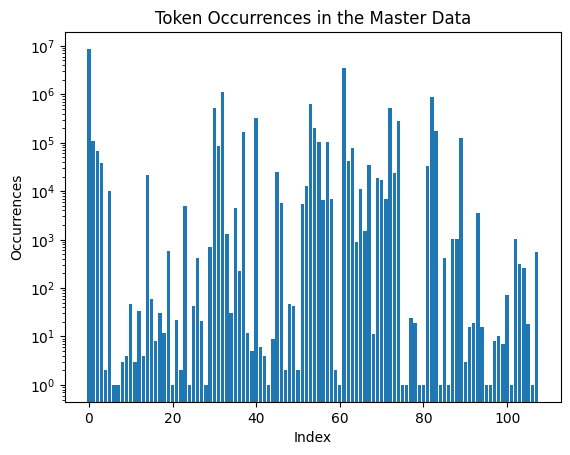

{'[nop]': 8622723, '[C]': 3533614, '[=C]': 1124749, '[Ring1]': 858760, '[Branch1]': 621078, '[=Branch1]': 523626, '[N]': 508932, '[=O]': 318166, '[O]': 279513, '[Branch2]': 202231, '[Ring2]': 177924, '[=N]': 169068, '[S]': 126691, '[#Branch1]': 110664, '[C@@H1]': 104643, '[C@H1]': 101674, '[=Branch2]': 85254, '[F]': 79420, '[#Branch2]': 66408, '[Cl]': 42797, '[#C]': 38534, '[NH1+1]': 35134, '[P]': 32584, '[=Ring1]': 25308, '[O-1]': 23915, '[/C]': 21745, '[NH1]': 18937, '[NH2+1]': 17342, '[Br]': 12715, '[N+1]': 10818, '[#N]': 10270, '[C@]': 7033, '[NH3+1]': 6788, '[C@@]': 6566, '[=Ring2]': 5738, '[=S]': 5554, '[/N]': 4849, '[=NH1+1]': 4577, '[\\C]': 3480, '[N-1]': 1475, '[=N+1]': 1279, '[\\N]': 1048, '[S@]': 1036, '[S@@]': 1008, '[I]': 887, '[/S]': 692, '[/NH1+1]': 572, '[\\S]': 555, '[/O]': 407, '[S-1]': 407, '[\\O-1]': 318, '[\\O]': 261, '[=NH2+1]': 226, '[\\NH1]': 72, '[/Cl]': 59, '[=S@@]': 47, '[/C@@H1]': 46, '[=S@]': 43, '[/O-1]': 42, '[/C@H1]': 34, '[/N+1]': 31, '[=N-1]': 30, '[P@

In [ ]:
#@title {vertical-output: true}
token_counts = Counter(master_set.flatten())
numbers = list(token_counts.keys())
occurrences = list(token_counts.values())

plt.bar(numbers, occurrences, align='center')
plt.xlabel('Index')
plt.ylabel('Occurrences')
plt.yscale('log')
plt.title('Token Occurrences in the Master Data')
plt.show()

token_counts = {idx_to_symbol[key]: value for key, value in token_counts.items()}
token_counts = {k: v for k, v in sorted(token_counts.items(), key=lambda item: item[1], reverse=True)}
print(token_counts)

### Length Visualization

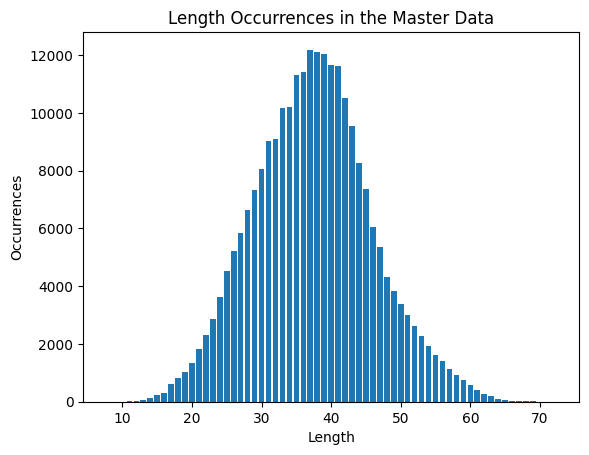

Sort based on length (ascending): {8: 3, 9: 3, 10: 5, 11: 16, 12: 20, 13: 61, 14: 118, 15: 233, 16: 308, 17: 612, 18: 824, 19: 1030, 20: 1330, 21: 1833, 22: 2316, 23: 2848, 24: 3641, 25: 4516, 26: 5213, 27: 5844, 28: 6641, 29: 7312, 30: 8071, 31: 9023, 32: 9097, 33: 10154, 34: 10197, 35: 11323, 36: 11412, 37: 12183, 38: 12115, 39: 12027, 40: 11639, 41: 11606, 42: 10495, 43: 9548, 44: 8252, 45: 7348, 46: 6054, 47: 5350, 48: 4324, 49: 3817, 50: 3393, 51: 2985, 52: 2606, 53: 2274, 54: 1934, 55: 1602, 56: 1415, 57: 1129, 58: 924, 59: 743, 60: 570, 61: 412, 62: 258, 63: 197, 64: 102, 65: 72, 66: 38, 67: 16, 68: 8, 69: 8, 70: 4, 72: 2}
Sort based on size (descending): {37: 12183, 38: 12115, 39: 12027, 40: 11639, 41: 11606, 36: 11412, 35: 11323, 42: 10495, 34: 10197, 33: 10154, 43: 9548, 32: 9097, 31: 9023, 44: 8252, 30: 8071, 45: 7348, 29: 7312, 28: 6641, 46: 6054, 27: 5844, 47: 5350, 26: 5213, 25: 4516, 48: 4324, 49: 3817, 24: 3641, 50: 3393, 51: 2985, 23: 2848, 52: 2606, 22: 2316, 53: 2274

In [ ]:
#@title {vertical-output: true}
length_counts = Counter([len(token)-(token == 0).sum() for token in master_set])
numbers = list(length_counts.keys())
occurrences = list(length_counts.values())

plt.bar(numbers, occurrences, align='center')
plt.xlabel('Length')
plt.ylabel('Occurrences')
plt.title('Length Occurrences in the Master Data')
plt.show()
length_counts = dict(sorted(length_counts.items()))
print("Sort based on length (ascending):", length_counts)
length_counts = dict(sorted(length_counts.items(), key=lambda item: item[1], reverse=True))
print("Sort based on size (descending):", length_counts)

### C.2. Data Splitting
Splits data into training/validation/test sets. Also determines length of padding needed.

In [ ]:
TRAIN_SIZE = math.floor(0.6*len(master_set))
VALIDATION_SIZE = math.floor(0.2*len(master_set))
TEST_SIZE = len(master_set) - (TRAIN_SIZE + VALIDATION_SIZE)

train_set = master_set[0:TRAIN_SIZE]
validation_set = master_set[TRAIN_SIZE:TRAIN_SIZE+VALIDATION_SIZE]
test_set = master_set[TRAIN_SIZE+VALIDATION_SIZE:TRAIN_SIZE+VALIDATION_SIZE+TEST_SIZE]

In [ ]:
start_token = vocab_size
end_token = vocab_size + 1

def addStartToken(x):
    return np.column_stack((start_token * np.ones(x.shape[0]), x[:, :-1])).astype(np.int16)

def addEndToken(x):
    for i in range(len(x)):
        row = x[i]
        if 0 in row:
            last_nonzero_index = len(row) - np.argmax(row[::-1] != 0) - 1
            x[i, last_nonzero_index + 1] = end_token
    return x.astype(np.int16)

def preprocessOffset(x):
    x = np.column_stack((start_token * np.ones(x.shape[0]), x[:, :-1]))
    # for i in range(len(x)):
    #     row = x[i]
    #     if 0 in row:
    #         last_nonzero_index = len(row) - np.argmax(row[::-1] != 0) - 1
    #         x[i, last_nonzero_index + 1] = end_token
    # return x.astype(np.int16)
    # return addEndToken(x)

    return x.astype(np.int16)

train_set_offset = addStartToken(train_set.copy())
validation_set_offset = addStartToken(validation_set.copy())

train_set_END = addEndToken(train_set.copy())
validation_set_END = addEndToken(validation_set.copy())

In [ ]:
train_set_offset = np.load("/content/drive/MyDrive/Colab Notebooks/Database/train_set_offset.npy")

## D. Custom Class and Methods

In [ ]:
def sampling(args):
    """Sampling from latent distribution."""
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], max_length, latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_var) * epsilon

## E. Building

### E.1. FULL Transformer Model

In [ ]:
#@title {vertical-output: true}
embed_dim = 64  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
latent_dim = 8 # Dimensions of latent reperesentation
beta = 1 # KL Annealing / KL divergence influence
transformer_blocks = 1 # no. of encoder and decoder blocks


encoder_input = Input((max_length,), dtype='int32', name='EncoderInput')
embedding_shared = Embedding(
    input_dim=vocab_size+2+3, # check
    output_dim=embed_dim,
    input_length=max_length,
    trainable=True,
    mask_zero=True,
    name='TokenEmbedding',
)
x = embedding_shared(encoder_input)
pos_encoding_shared = SinePositionEncoding(name='PositionEmbedding')
x = Add(name='EmbAddPos')([x, pos_encoding_shared(x)])
for i in range(transformer_blocks):
    layer_name = f'TransformerEncoder_{i+1}'
    x = TransformerEncoder(
        intermediate_dim=ff_dim,
        num_heads=num_heads,
        dropout=0,
        name=layer_name)(x)
z_mean = Dense(latent_dim, name='DenseMean')(x)
z_log_var = Dense(latent_dim, name='DenseLogVar')(x)
z = Lambda(sampling, name='LatentDense')([z_mean, z_log_var])
encoder = Model(encoder_input, [z_mean, z_log_var, z], name="ChemVATSEncoder")

encoder_output = Input((max_length,latent_dim,), name='EncoderOutput')
y = Dense(embed_dim, activation='relu', name='DenseDecoderExpand')(encoder_output)
decoder_input = Input((max_length,), dtype='int32', name='DecoderInput')
x = embedding_shared(decoder_input)
x = Add(name='EmbAddPos2')([x, pos_encoding_shared(x)])
for i in range(transformer_blocks):
    layer_name = f'TransformerDecoder_{i+1}'
    x = TransformerDecoder(
        intermediate_dim=ff_dim,
        num_heads=num_heads,
        dropout=0,
        name=layer_name)(x, y)
output = Dense(vocab_size+1, activation='softmax', name='FinalDense')(x)
decoder = Model([decoder_input, encoder_output], output, name="ChemVATSDecoder")

vae_output = decoder([decoder_input, encoder(encoder_input)[2]])
vae = Model([encoder_input, decoder_input], vae_output, name="ChemVATS")

reconstruction_loss = keras.losses.sparse_categorical_crossentropy(encoder_input, vae_output)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
vae.add_loss(vae_loss)

vae.compile(
    optimizer = 'adam',
    metrics=['sparse_categorical_accuracy'],
)

vae.summary(
    expand_nested=True,
    layer_range=["ChemVATSEncoder", "ChemVATSDecoder"]
)

Model: "ChemVATS"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ChemVATSEncoder (Functiona  [(None, 72, 8),              29360     ['EncoderInput[0][0]']        
 l)                           (None, 72, 8),                                                      
                              (None, 72, 8)]                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| EncoderInput (InputLayer)  [(None, 72)]                 0         []                           |
|                                                                                                |
| TokenEmbedding (Embedding  (None, 72, 64)               7232      ['EncoderInput[0][0]']       |
| )                                                                                        

VAE Loss is defined as follows

$\text{Total Loss} = \mathcal{L}(x,\hat{x}) + \beta \times \sum_j \text{KL} \Big(q_j(z|x) \,||\, N(0,1)\Big)$

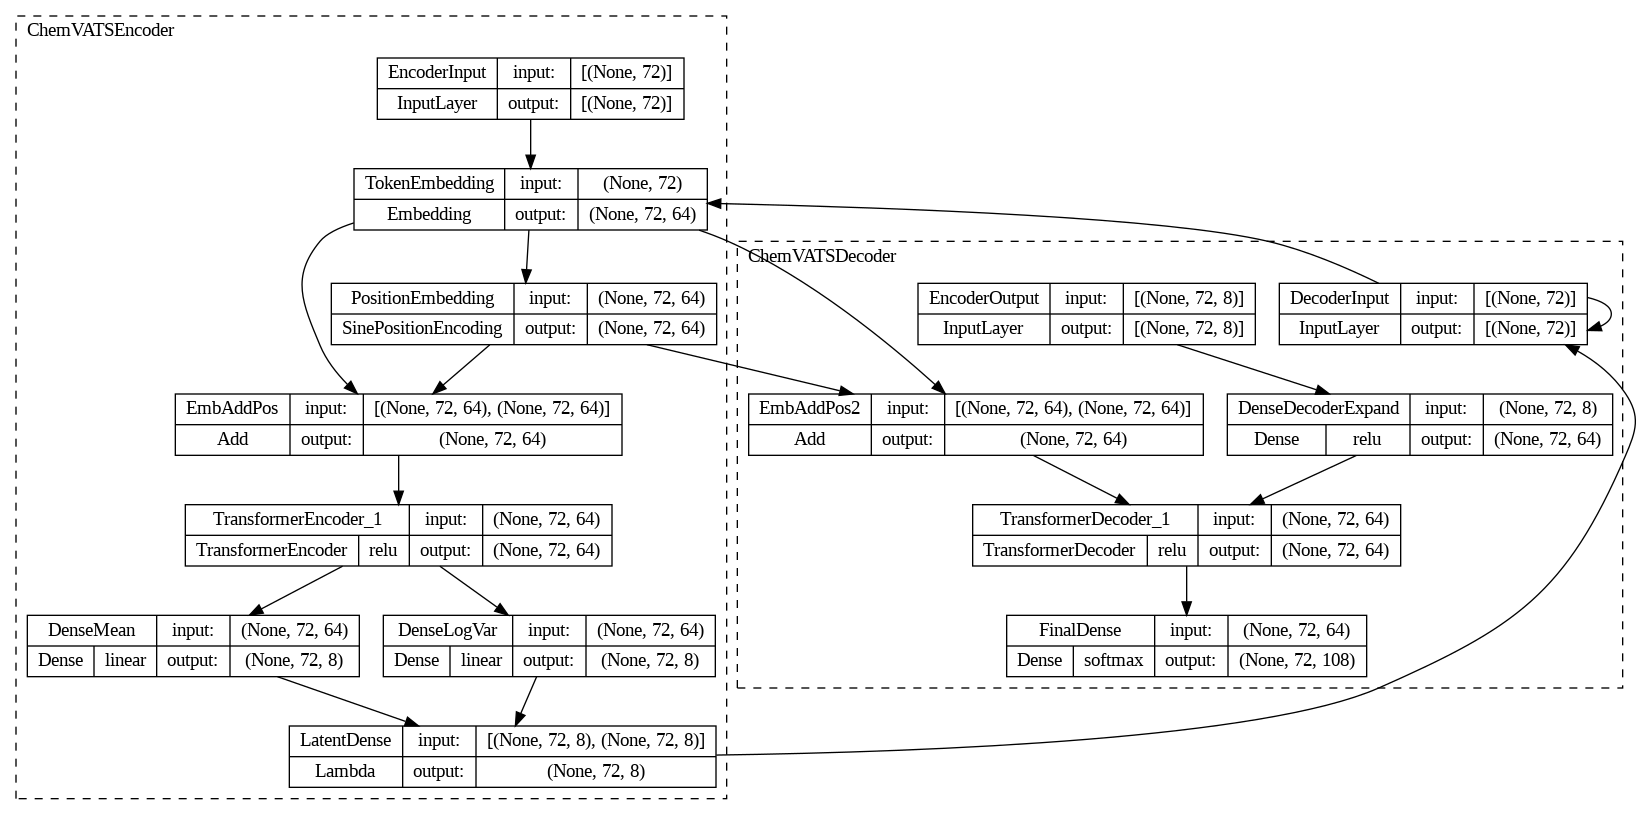

In [ ]:
#@title {vertical-output: true}
keras.utils.plot_model(
    vae,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=["ChemVATSEncoder", "ChemVATSDecoder"],
    show_layer_activations=True,
)

### E.2. Training and Testing

#### Callbacks
Checkpoint weight saving and Early Stop.

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Colab Notebooks/Models/weightsCheckpoint.hdf5', #weights.{epoch:02d}-{val_loss:.2f}.hdf5'
    save_weights_only = True,
    monitor = 'val_loss', #'val_sparse_categorical_accuracy'
    mode = 'min',
    save_best_only = True,
    # verbose = True,
)

early_stop = keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  mode = 'min',
  patience = 10,
  min_delta = 0.0001,
  verbose = True,
)

backup = keras.callbacks.BackupAndRestore(
    backup_dir="/content/drive/MyDrive/Colab Notebooks/Backup/"
)

%load_ext tensorboard
tb = keras.callbacks.TensorBoard(
    log_dir='/content/drive/MyDrive/Colab Notebooks/Tensorboard/',
    histogram_freq=0,
    write_graph=True,
    write_images=True,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)

#### Fit or Loading

In [ ]:
TRAIN_LOAD = "TRAIN"

# Training
TRAIN_SAVE = True
EPOCHS = 100
BATCH_SIZE = 64    # Change `BATCH_SIZE` (ex. 100 or 128) to something large when using a GPU. When using CPU use around 32. :)
# TRAIN_WEIGHTS_FILE = "/content/drive/MyDrive/Colab Notebooks/Models/ChemVATS_weights.h5" #MAIN
TRAIN_WEIGHTS_FILE = "/content/drive/MyDrive/Colab Notebooks/Models/ChemVATSBranch3_weights.h5"
TRAIN_WEIGHTS_FILE = "/content/drive/MyDrive/Colab Notebooks/Models/ChemVATS250k.h5"
# TRAIN_WEIGHTS_FILE = "/content/drive/MyDrive/Colab Notebooks/Models/ChemVATStemp_weights.h5"
# Branch 1 = 1 epoch, Brach 2 = with END and offset, Branch 3 = 250k


# Loading
CHECKPOINT_LOAD = False


#------------
assert TRAIN_LOAD == "TRAIN" or TRAIN_LOAD == "LOAD", "Wrong value in TRAIN_LOAD"
if TRAIN_LOAD == "TRAIN":
    print("TRAINING!")

    for i in range(len(vae.weights)):
        vae.weights[i]._handle_name = vae.weights[i].name + "_" + str(i)

    history = vae.fit(
        x = [train_set, train_set_offset],
        y = train_set_END,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        shuffle = True,
        validation_data = ([validation_set, validation_set_offset], validation_set_END),
        callbacks = [
            checkpoint,
            early_stop, # may be disabled to prevent premature early stop
            backup,
            # tb, # may crash training
        ],
    )
    if TRAIN_SAVE:
        vae.save_weights(TRAIN_WEIGHTS_FILE)
        print("SAVE succesful!")
elif TRAIN_LOAD == "LOAD":
    if CHECKPOINT_LOAD:
        vae.load_weights('/content/drive/MyDrive/Colab Notebooks/Models/weightsCheckpoint.hdf5')
    else:
        vae.load_weights(TRAIN_WEIGHTS_FILE)
    print("LOAD succesful!")

TRAINING!


ValueError: Received incompatible tensor with shape (108,) when attempting to restore variable with shape (109,) and name FinalDense/bias:0_50.

#### Autoregressive Inference

In [ ]:
NUM_BEAMS = 3

def encodeTransformer(input_seq):
    return encoder(np.expand_dims(input_seq,0))[2]

def decodeTransformer(encoder_output):
    def next(prompt, cache, index):
        logits = decoder([prompt, encoder_output])[:, index - 1, :]
        hidden_states = None
        return logits, hidden_states, cache

    decoded_molecule = np.zeros((1, max_length))
    decoded_molecule[0,0] = start_token

    encoder_output = tf.repeat(encoder_output, NUM_BEAMS, axis=0)
    decoded_molecule = BeamSampler(num_beams=NUM_BEAMS)( # GreedySampler, BeamSampler, TopKSampler, TopPSampler
        next = next,
        prompt = decoded_molecule,
        end_token_id = end_token,
        index = 1,
    )

    # decoded_molecule = TopPSampler(p=0.8, k=5)( # GreedySampler, BeamSampler, TopKSampler, TopPSampler
    #     next = next,
    #     prompt = decoded_molecule,
    #     end_token_id = end_token,
    #     index = 1,
    # )
    return np.array(decoded_molecule)[0][1:].astype(np.int16)

def autoencode(input_seq):
    return decodeTransformer(encodeTransformer(input_seq))

#### Learning Graphs and Tensorboard

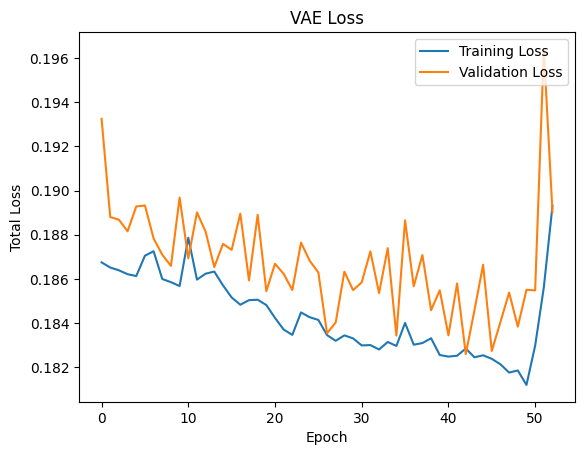

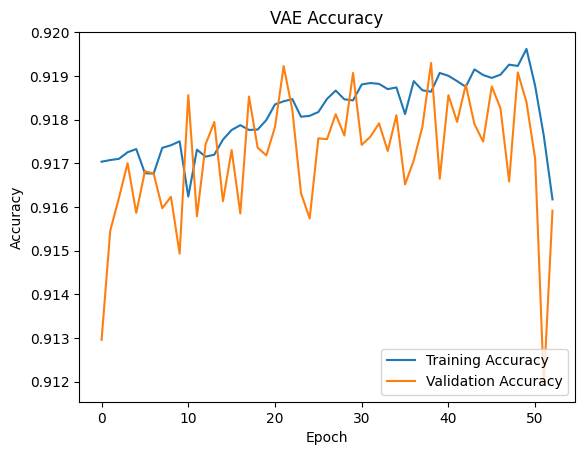

In [ ]:
#@title {vertical-output: true}
# Total Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Accuracy Plot
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('VAE Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/Tensorboard/'

## E. Test

In [ ]:
def smiles_to_encoding_test(x):
    x = sf.encoder(x)
    x = sf.selfies_to_encoding(selfies=x, vocab_stoi=symbol_to_idx, pad_to_len=max_length, enc_type="label")
    return np.expand_dims(x,0)

def encoding_to_smiles_test(x):
    x = sf.encoding_to_selfies(encoding=x, vocab_itos=idx_to_symbol, enc_type="label")
    x = sf.decoder(x)
    print(x)
    return x

### Evaluate Loss and Accuracy on Test Set

In [ ]:
vae.evaluate(
    x = test_set,
    y = test_set
)

 219/1563 [===>..........................] - ETA: 48s - loss: 0.0879 - sparse_categorical_accuracy: 0.9951

KeyboardInterrupt: ignored

In [ ]:
test = vae([np.expand_dims(train_set[0],0),np.expand_dims(train_set_offset[0],0)])
print(np.argmax(test,2))

[[67 67 67 33 80 67 43 54 67 31 67 39 77 60 67 77 54  2 67 67 67 33 67 33
  95 88 54 67 67 88 77 54 67 67 67  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [ ]:
train_set[0]

array([67, 67, 67, 33, 80, 67, 43, 54, 67, 31, 67, 39, 77, 60, 67, 77, 54,
        2, 67, 67, 67, 33, 67, 33, 95, 88, 54, 67, 67, 88, 77, 54, 67, 67,
       67,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int8)

### Position Comparison

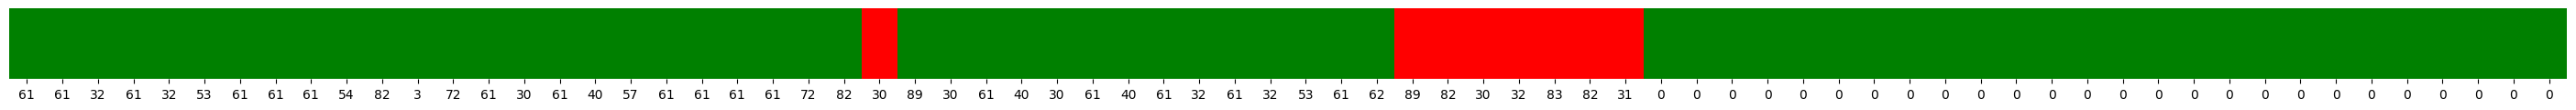

SUMMARY: 64 correct out of 72 / 88.88888888888889% accuracy


In [ ]:
#@title {vertical-output: true}
test = random.randint(0, TEST_SIZE)
test1 = test_set[test]
test2 = autoencode(test_set[test])

# test1 = train_set[0]
# test2 = autoencode(train_set[0])

test2 = np.pad(test2, (0, 1), constant_values= 0)

differences = np.array(test1) != np.array(test2)
heatmap_data = differences.reshape(1, -1)
plt.figure(figsize=(len(test1) // 2, 1))
sns.heatmap(heatmap_data, cmap=['green', 'red'], cbar=False, annot=False)
plt.xticks(np.arange(len(test1)) + 0.5, labels=test1)
plt.yticks([])
plt.show()

# for elem1, elem2 in zip(test1, test2):
#     if elem1 != elem2:
#         print(colored(f'Difference: {elem1} (Array 1) != {elem2} (Array 2)', 'red'))
#     else:
#         print(f'Match: {elem1} == {elem2}')

# WORKS ON GOOGLE COLAB ONLY
print(f"SUMMARY: {max_length - np.sum(differences)} correct out of {max_length} / {(max_length - np.sum(differences)) / max_length * 100}% accuracy")
for elem1, elem2 in zip(test1, test2):
    if elem1 == elem2:
        display(HTML(f"<span style='color:green'>Correct: {elem1} == {elem2}</span>"))
    else:
        display(HTML(f"<span style='color:red'>Incorrect: {elem1} != {elem2}</span>"))

### Generate Latent Vector and Reconstruct Figure

Original SMILES:      O1C=C[C@H]([C@H]1O2)c3c2cc(OC)c4c3OC(=O)C5=C4CCC(=O)5
Reconstructed SMILES: O=CC[C@H1]([C@H1][C@H1]C=CC1=CC=COC)C2=C1OC(=O)CC2CCC(=O)[O-1]
Orig.png


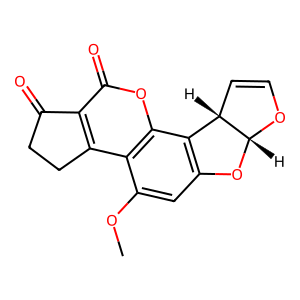

Re.png


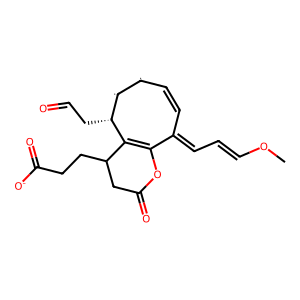

In [ ]:
#@title {vertical-output: true}
extraInfo = False
dataMode = 3 # 1 for train-data ONLY, 2 for ALL data, 3 for custom

if dataMode == 1:
    test = data_SMILES.iloc[random.randint(50_000,60_000),0]
elif dataMode == 2:
    test = data_SMILES.iloc[random.randint(200_000, len(data_SMILES)-1),0]
elif dataMode == 3:
    test = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
    test = 'FP(=O)(OC(C)C)C'
    test = 'O1C=C[C@H]([C@H]1O2)c3c2cc(OC)c4c3OC(=O)C5=C4CCC(=O)5'
test_i = test
if extraInfo: print("SMILES:", test)
test = sf.encoder(test)
if extraInfo: print("SELFIES", test)
test = sf.selfies_to_encoding(
        selfies = test,
        vocab_stoi = symbol_to_idx,
        pad_to_len = max_length,
        enc_type = "label"
    )
if extraInfo: print("SELFIES Encoding:", test)
latent_vector = encoder.predict(np.expand_dims(test,0),verbose=0)[2]
if extraInfo: print("Latent Vector:\n", latent_vector, "\n")
test = autoencode(test)
if extraInfo: print("Recreated Input:", test)
if extraInfo: print("Recreated Input from Latent Vector:", decodeTransformer(latent_vector))
test = sf.encoding_to_selfies(
    encoding = test,
    vocab_itos = idx_to_symbol,
    enc_type = "label"
)
if extraInfo: print("Reconstructed SELFIES:", test)
test = sf.decoder(test)
print("Original SMILES:     ", test_i)
print("Reconstructed SMILES:", test)
Draw.MolToFile(Chem.MolFromSmiles(test_i),'Orig.png')
Draw.MolToFile(Chem.MolFromSmiles(test),'Re.png')

listOfImageNames = ['Orig.png',
                    'Re.png']

for imageName in listOfImageNames:
    print(imageName);display(Image(filename=imageName, width=300))

### Embedding Arithmetic

O=CNCCCCCC1CNCCCCCOCO1


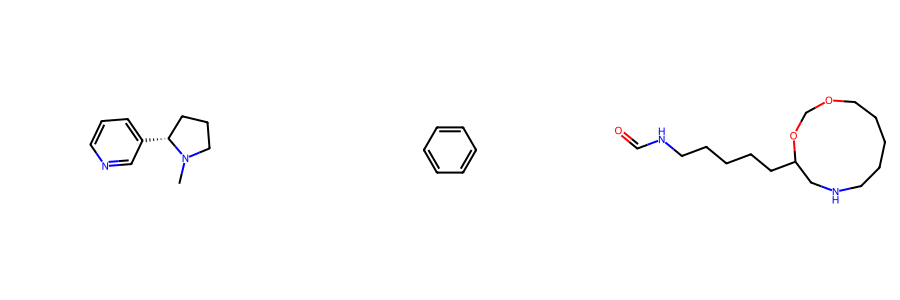

In [ ]:
test1 = "c1ncccc1[C@@H]2CCCN2C"
test2 = "c1ccccc1"

test_list = [test1, test2]
test1 = smiles_to_encoding_test(test1)
test2 = smiles_to_encoding_test(test2)

test = (encoder(test1)[2] + encoder(test2)[2]) / 2
test = decodeTransformer(test)
test = encoding_to_smiles_test(test)
test_list.append(test)
test_list = [Chem.MolFromSmiles(smiles) for smiles in test_list]
mol_matrix = [test_list[i:i + 3] for i in range(0, len(test_list), 3)]
img = Draw.MolsMatrixToGridImage(mol_matrix, subImgSize=(300, 300))
display(img)

### Interpolate

O=CNC1=CC=C(O)CC(O)C2NC(C)CC2=C1C(=O)[O-1]
O=CNC=CC1=C(O)CC(O)CNC(C2)CC=CC=C12
O=C(NC=CC1=CC=CO1)C=CC
O=CCC1=CC=CC=C1C(C)C(C)CC2=CC=CC=C2
O=CCCC=CC=CC(=O)C(C)CCCCC1=CC=CC=C1
O=C(C1=CC=CC=C1OCC(O)CNCCC)CCC2=CC=CC=C2
O=C(C1=CC=CC=C1OCC(O)CNCCC)CCC2=CC=CC=C2


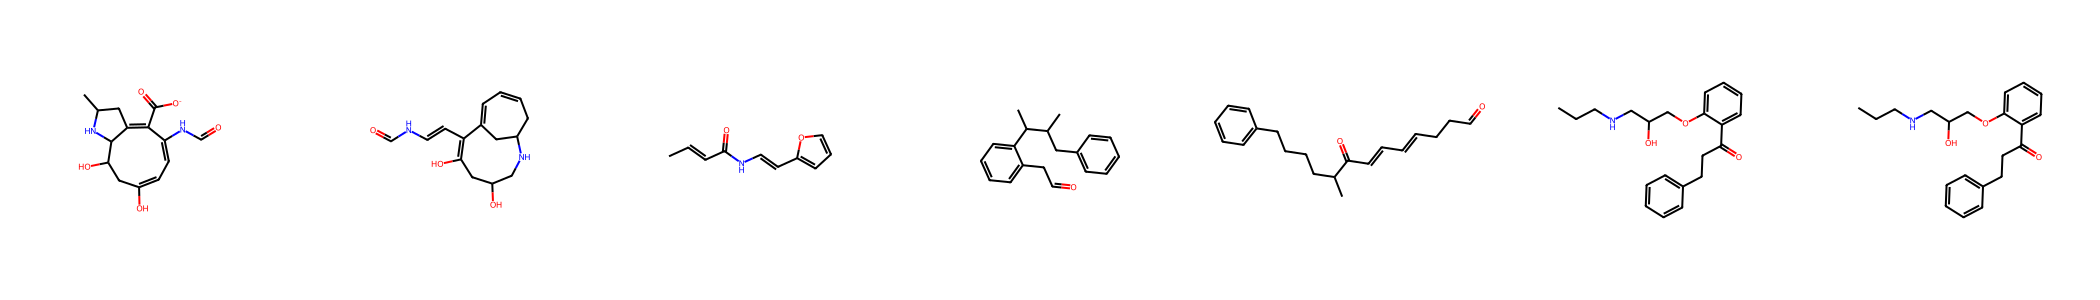

In [ ]:
#@title {vertical-output: true}
MODE = 2 # 1 for random test value, 2 for custom
num_steps = 5
COLS = 7

initial = 'O=C(Nc1ccc(OCC(O)CNC(C)C)c(c1)C(=O)C)CCC'
final = 'O=C(c1ccccc1OCC(O)CNCCC)CCc2ccccc2'


#-----------------------------------
assert MODE == 1 or MODE == 2, "Wrong value in MODE"
if MODE == 1:
    initial = [test_set[random.randint(0,TEST_SIZE)].tolist()]
    final = [test_set[random.randint(0,TEST_SIZE)].tolist()]
elif MODE == 2:
    initial = smiles_to_encoding_test(initial)
    final = smiles_to_encoding_test(final)

z1 = encodeTransformer(np.squeeze(initial))
z2 = encodeTransformer(np.squeeze(final))

interpolated_data_points = []
for i in range(num_steps):
    alpha = (i + 1) / (num_steps + 1)  # Interpolation coefficient
    interpolated_latent_point = (1 - alpha) * z1 + alpha * z2
    interpolated_data_points.append(decodeTransformer(interpolated_latent_point))

# DECODING and Graphing -----------------
test_list = []
test_list.append(encoding_to_smiles_test(np.squeeze(decodeTransformer(z1))))
for i in range(num_steps):
    test_list.append(encoding_to_smiles_test(interpolated_data_points[i]))
test_list.append(encoding_to_smiles_test(np.squeeze(decodeTransformer(z2))))

test_list = [Chem.MolFromSmiles(smiles) for smiles in test_list]
mol_matrix = [test_list[i:i + COLS] for i in range(0, len(test_list), COLS)]
img = Draw.MolsMatrixToGridImage(mol_matrix, subImgSize=(300, 300))
display(img)

### Graphing Latent Space

Principal Component Analysis (PCA)

1560/1560 [==============================] - 52s 33ms/step


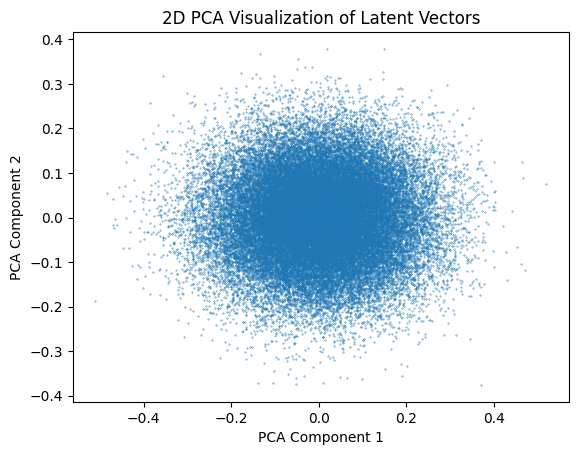

In [ ]:
#@title {vertical-output: true}
from sklearn.decomposition import PCA

latent_vectors = np.mean(encoder.predict(test_set)[2],axis=1)
# latent_vectors = encoder.predict(test_set)[2].reshape(TEST_SIZE, max_length*latent_dim)
pca = PCA(n_components=2)
latent_vectors_2d = pca.fit_transform(latent_vectors)
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], s=0.1)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Visualization of Latent Vectors')
plt.show()

T-distributed Stochastic Neighbor Embedding (TSNE)

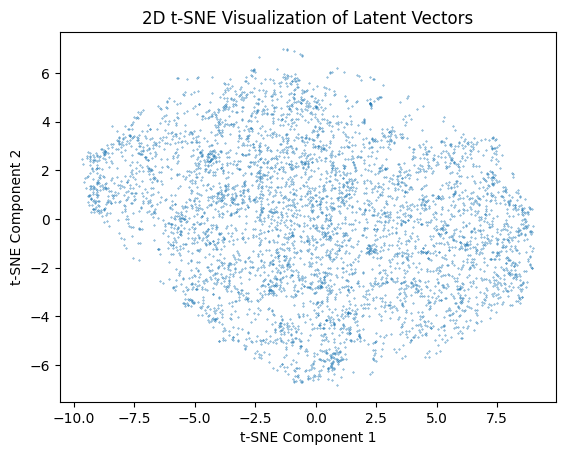

In [ ]:
#@title {vertical-output: true}
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
latent_vectors_2d_tsne = tsne.fit_transform(latent_vectors[1:5000])
plt.scatter(latent_vectors_2d_tsne[:, 0], latent_vectors_2d_tsne[:, 1], s=0.1)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D t-SNE Visualization of Latent Vectors')
plt.show()

### Transfer Learning
adapted from https://keras.io/examples/generative/molecule_generation/

In [ ]:
csv_path = keras.utils.get_file(
    "/content/250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("/content/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.head(100)

22606589/22606589 [==============================] - 0s 0us/step


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182
...,...,...,...,...
95,C=CCN(Cc1cccc([N+](=O)[O-])c1)C(=O)Nc1cc(OC)cc...,4.47690,0.419977,2.204004
96,Cc1cc(Cl)ccc1OCC(=O)N/N=C/c1ccccn1,2.57252,0.680288,2.075582
97,O=C1NC(=S)NC(=O)C1=CNc1ccc([N+](=O)[O-])cc1O,0.12710,0.159707,2.703933
98,Cc1c(C(=O)N2CCOCC2)oc2c1-c1nn(CC(=O)NCc3ccco3)...,1.93192,0.675385,2.845261


In [ ]:
master_df = df.sample(frac=1, random_state=42)  # random state is a seed value
master_df.reset_index(drop=True, inplace=True)

master_smiles_set, master_prop_set = [], []
for idx in range(len(master_df)):
    master_smiles_set.append(master_df.loc[idx]["smiles"])
    master_prop_set.append(master_df.loc[idx]["logP"])

master_selfies_set = [sf.encoder(s) for s in master_smiles_set]
master_encoding_set = [sf.selfies_to_encoding(
                                selfies = s,
                                vocab_stoi = symbol_to_idx,
                                pad_to_len = max_length,
                                enc_type = "label"
                            ) for s in master_selfies_set]
master_encoding_set = np.array(master_encoding_set)
master_prop_set = np.array(master_prop_set)

test = math.floor(0.8*len(master_encoding_set))
train_encoding_set = master_encoding_set[0:test]
train_prop_set = master_prop_set[0:test]
test_encoding_set = master_encoding_set[test+1:len(master_encoding_set)]
test_prop_set = master_prop_set[test+1:len(master_prop_set)]

Model: "TestNeuralNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TestInput (InputLayer)      [(None, 72)]              0         
                                                                 
 TokenEmbedding (Embedding)  (None, 72, 64)            7104      
                                                                 
 DenseExpand (Dense)         (None, 72, 64)            4160      
                                                                 
 DenseExpand2 (Dense)        (None, 72, 108)           7020      
                                                                 
 DenseExpand3 (Dense)        (None, 72, 108)           11772     
                                                                 
 GlobalAveragePooling1D (Gl  (None, 108)               0         
 obalAveragePooling1D)                                           
                                                 

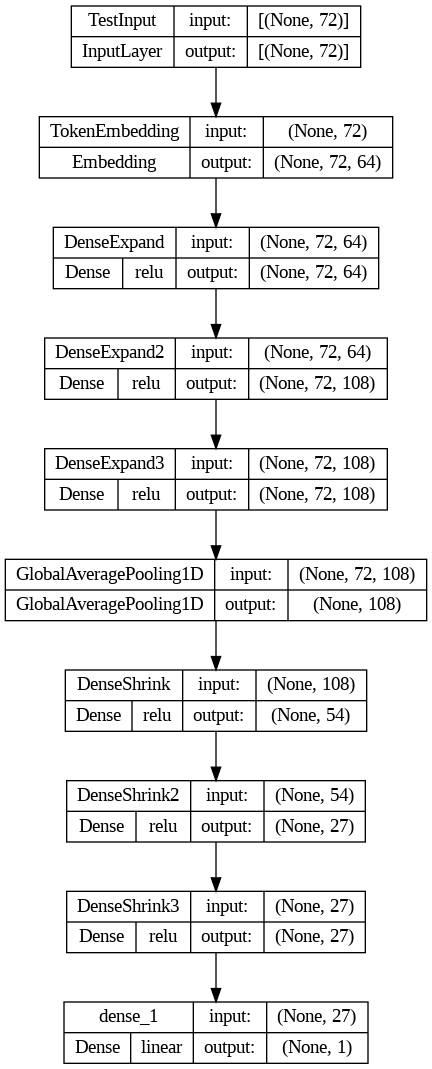

In [ ]:
#@title {vertical-output: true}
testNN_input = Input((max_length,), dtype='int32', name='TestInput')
x = Embedding(
    input_dim=vocab_size+2+1,
    output_dim=embed_dim,
    input_length=max_length,
    trainable=True,
    mask_zero=True,
    name='TokenEmbedding',
)(testNN_input)
x = Dense(64, activation='relu', name="DenseExpand")(x)
x = Dense(vocab_size, activation='relu', name="DenseExpand2")(x)
x = Dense(vocab_size, activation='relu', name="DenseExpand3")(x)
x = GlobalAveragePooling1D(name="GlobalAveragePooling1D")(x)
x = Dense(vocab_size/2, activation='relu', name="DenseShrink")(x)
x = Dense(vocab_size/4, activation='relu', name="DenseShrink2")(x)
x = Dense(vocab_size/4, activation='relu', name="DenseShrink3")(x)
testNN_output = Dense(1, activation='linear')(x)

testNN = Model(testNN_input, testNN_output, name="TestNeuralNetwork")
testNN.compile(optimizer = "adam", loss = 'mse')
testNN.summary()

keras.utils.plot_model(
    testNN,
    to_file="modelTestNN.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    # expand_nested=True,
    dpi=96,
    show_layer_activations=True,
)

Model: "TestNeuralNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TestInput (InputLayer)      [(None, 72)]              0         
                                                                 
 ChemVATSEncoder (Functiona  [(None, 72, 8),           29232     
 l)                           (None, 72, 8),                     
                              (None, 72, 8)]                     
                                                                 
 DenseExpand (Dense)         (None, 72, 64)            576       
                                                                 
 DenseExpand2 (Dense)        (None, 72, 108)           7020      
                                                                 
 DenseExpand3 (Dense)        (None, 72, 108)           11772     
                                                                 
 GlobalAveragePooling1D (Gl  (None, 108)         

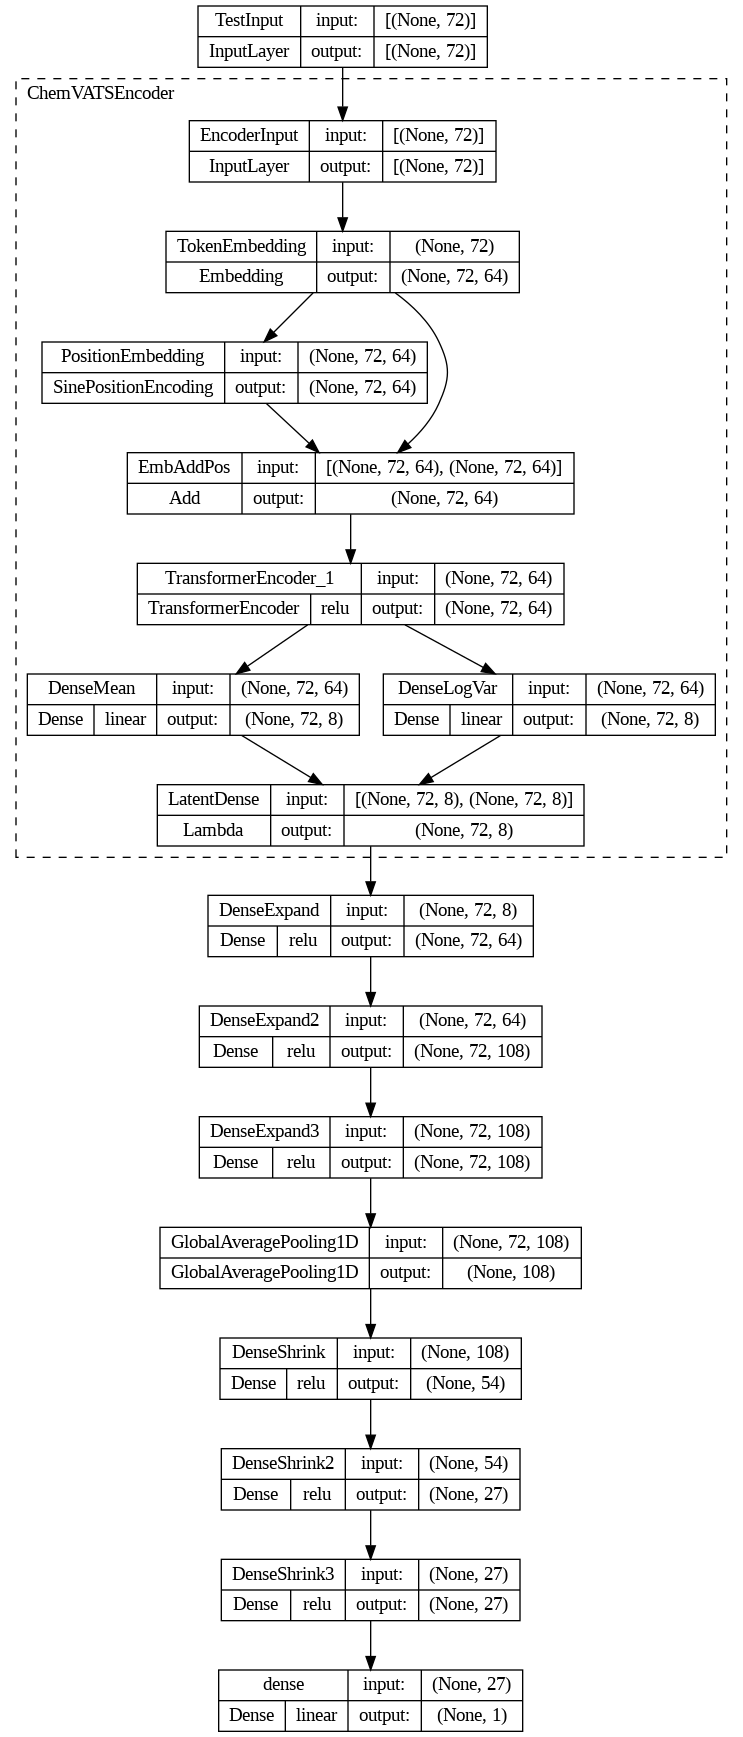

In [ ]:
#@title {vertical-output: true}
testNN_input = Input((max_length,), dtype='int32', name='TestInput')
x = encoder(testNN_input)[2]; encoder.trainable = False
x = Dense(64, activation='relu', name="DenseExpand")(x)
x = Dense(vocab_size, activation='relu', name="DenseExpand2")(x)
x = Dense(vocab_size, activation='relu', name="DenseExpand3")(x)
x = GlobalAveragePooling1D(name="GlobalAveragePooling1D")(x)
x = Dense(vocab_size/2, activation='relu', name="DenseShrink")(x)
x = Dense(vocab_size/4, activation='relu', name="DenseShrink2")(x)
x = Dense(vocab_size/4, activation='relu', name="DenseShrink3")(x)
testNN_output = Dense(1, activation='linear')(x)

testNN = Model(testNN_input, testNN_output, name="TestNeuralNetwork")
testNN.compile(optimizer = "adam", loss = 'mse')
testNN.summary()

keras.utils.plot_model(
    testNN,
    to_file="modelTestNN.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    # expand_nested=True,
    dpi=96,
    show_layer_activations=True,
)

In [ ]:
for i in range(len(testNN.weights)):
    testNN.weights[i]._handle_name = testNN.weights[i].name + "_" + str(i)

test_history = testNN.fit(
    x = train_encoding_set,
    y = train_prop_set,
    epochs = 200,
    batch_size = 64,
    shuffle = True,
    validation_split = 0.1,
)

Epoch 1/200
2807/2807 [==============================] - 36s 12ms/step - loss: 0.7317 - val_loss: 0.6368
Epoch 2/200
2807/2807 [==============================] - 26s 9ms/step - loss: 0.5503 - val_loss: 0.5833
Epoch 3/200
2807/2807 [==============================] - 18s 7ms/step - loss: 0.5416 - val_loss: 0.5452
Epoch 4/200
2807/2807 [==============================] - 19s 7ms/step - loss: 0.5421 - val_loss: 0.5921
Epoch 5/200
2807/2807 [==============================] - 19s 7ms/step - loss: 0.5377 - val_loss: 0.5283
Epoch 6/200
2807/2807 [==============================] - 19s 7ms/step - loss: 0.5326 - val_loss: 0.5444
Epoch 7/200
2807/2807 [==============================] - 19s 7ms/step - loss: 0.5268 - val_loss: 0.5173
Epoch 8/200
2807/2807 [==============================] - 18s 6ms/step - loss: 0.5197 - val_loss: 0.5302
Epoch 9/200
2807/2807 [==============================] - 20s 7ms/step - loss: 0.5079 - val_loss: 0.4991
Epoch 10/200
2807/2807 [==============================] - 18s 7

In [ ]:
# testNN.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/TestNN_logP_weights.h5")
testNN.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/TestNN_logP_weights_NOTRANSFORMER.h5")

In [ ]:
test = random.randint(0,10_000)
print(master_smiles_set[test])
print("Actual:     ", master_prop_set[test], "\nPrediction: ", testNN.predict(np.expand_dims(master_encoding_set[test],0), verbose=0)[0,0])

COc1ccc(NC(=O)Cc2nc3nc(C)c(Cl)c(C)n3n2)c(OC)c1
Actual:      2.59294 
Prediction:  3.165212


1560/1560 [==============================] - 4s 3ms/step


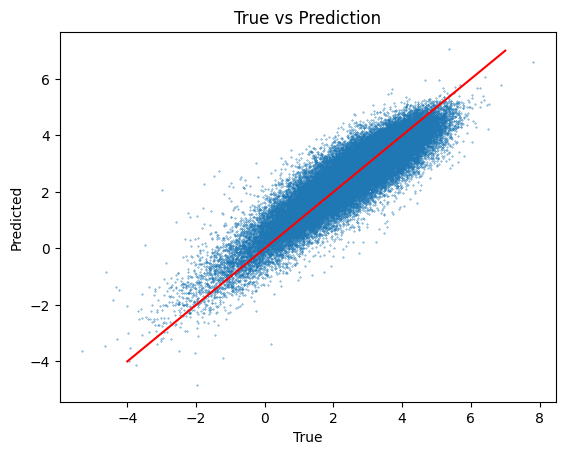

In [ ]:
#@title {vertical-output: true}
test = testNN.predict(test_encoding_set)
plt.scatter(test_prop_set, test, s=0.1)
plt.plot(np.array([-4,7]), np.array([-4,7]), label='y = x', color='red')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs Prediction')
plt.show()

In [ ]:
print(f'RMSE = {math.sqrt(testNN.evaluate(test_encoding_set,test_prop_set))}')

1560/1560 [==============================] - 5s 3ms/step - loss: 0.3722
RMSE = 0.6100519039788106


# OTHERS

In [ ]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
model = Sequential([Embedding(input_dim=5+1, output_dim=2, input_length=5), Flatten()])
model.compile('rmsprop', 'mse')
model.predict(tf.constant([[1,2,3,4,5],[5,5,5,5,5]]))

1/1 [==============================] - 0s 177ms/step


array([[-0.00806739, -0.02008803, -0.00773904, -0.00908155,  0.02701206,
        -0.03173574,  0.01688141,  0.02214426, -0.02796904,  0.00033376],
       [-0.02796904,  0.00033376, -0.02796904,  0.00033376, -0.02796904,
         0.00033376, -0.02796904,  0.00033376, -0.02796904,  0.00033376]],
      dtype=float32)

In [ ]:
np.array([1,2,3])